In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

# Causal discovery
import lingam

# SEM
import semopy

# Causal infernece
from dowhy import gcm
import networkx as nx

np.random.seed(0)

# Test data
linear, acyclic, non-gaussian(uniform)

## Causal graph

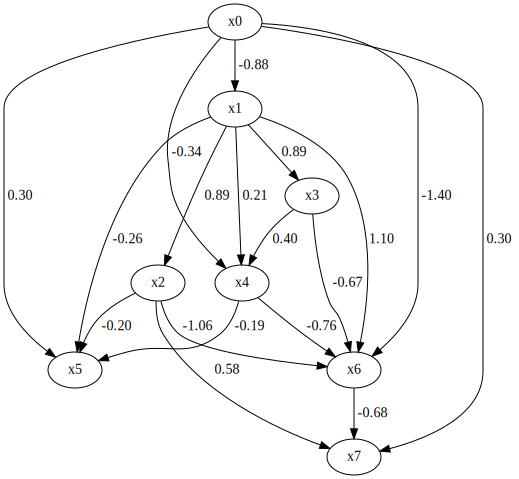

## Histogram

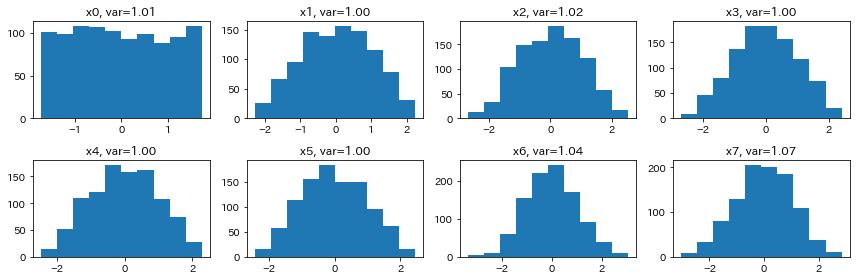

In [2]:
true_B = np.array([
    [ 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.0, 0.000000, 0.0],
    [-0.884741, 0.000000,-0.000000, 0.000000,-0.000000,-0.0, 0.000000, 0.0],
    [-0.000000, 0.890683, 0.000000,-0.000000,-0.000000,-0.0,-0.000000, 0.0],
    [-0.000000, 0.890683,-0.000000,-0.000000, 0.000000,-0.0, 0.000000, 0.0],
    [-0.338349, 0.207002, 0.000000, 0.397703, 0.000000, 0.0, 0.000000, 0.0],
    [ 0.303426,-0.255993,-0.195916,-0.000000,-0.193382, 0.0,-0.000000, 0.0],
    [-1.397784, 1.103831,-1.059028,-0.672126,-0.757459, 0.0,-0.000000, 0.0],
    [ 0.296532, 0.000000, 0.578578, 0.000000,-0.000000, 0.0,-0.676613, 0.0],
])
display(Markdown("## Causal graph"))
display(lingam.utils.make_dot(true_B))

n_samples = 1000
n_features = len(true_B)
e_ratio = 0.2
e = np.array([
    np.random.uniform(-np.sqrt(3), np.sqrt(3), size=n_samples),
    *np.random.uniform(-np.sqrt(3 * e_ratio), np.sqrt(3 * e_ratio), size=(7, n_samples)),
])
A = np.linalg.pinv(np.eye(n_features) - true_B)
X = pd.DataFrame((A @ e).T, columns=[f"x{i}" for i in range(n_features)])

display(Markdown("## Histogram"))
n_cols = 4
n_rows = n_features // n_cols + (n_features % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows))
for i, (name, x) in enumerate(X.items()):
    ax = axes.flatten()[i]
    ax.hist(x)
    ax.set_title(f"{name}, var={np.var(x):.2f}")
for ax in axes.flatten()[n_features:]:
    ax.remove()
plt.tight_layout()
plt.show()

# Causal discovery

In [3]:
model = lingam.DirectLiNGAM()
model.fit(X)
est_adj = model.adjacency_matrix_

display(Markdown("## Estimated adjacency matrix"))
display(pd.DataFrame(est_adj).style.format(lambda x: f"{x:.2f}"))

## Estimated adjacency matrix

,0,1,2,3,4,5,6,7
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.91,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.90,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.35,0.17,0.00,0.42,0.00,0.00,0.00,0.00
5,0.31,-0.24,-0.21,0.00,-0.19,0.00,0.00,0.00
6,-1.41,1.17,-1.08,-0.70,-0.78,0.00,0.00,0.00
7,0.31,0.00,0.60,0.00,0.00,0.00,-0.67,0.00


# to semopy

In [4]:
def to_semopy_desc(adj):
    desc = ""
    for i, coefs in enumerate(adj):
        if np.isclose(coefs, 0).all():
            continue
        
        terms = []
        for j, coef in enumerate(coefs):
            if np.isclose(coef, 0):
                continue
            
            terms.append(f"{coef}*x{j}")
        desc += f"x{i} ~ " + " + ".join(terms) + "\n"
        
    return desc

desc = to_semopy_desc(est_adj)
print(desc)

model = semopy.Model(desc)
model.fit(X)

model.inspect()

x1 ~ -0.8819729037999137*x0
x2 ~ 0.9056192987190254*x1
x3 ~ 0.8963826477598307*x1
x4 ~ -0.3529786611360607*x0 + 0.17179150732962534*x1 + 0.41858069288932953*x3
x5 ~ 0.31151401323922506*x0 + -0.24196544750539584*x1 + -0.20735916462880324*x2 + -0.18646165997875963*x4
x6 ~ -1.4083600660122717*x0 + 1.167137974234743*x1 + -1.0813063469780964*x2 + -0.703693157907496*x3 + -0.7835605957323628*x4
x7 ~ 0.3129084951008146*x0 + 0.5988632282173669*x2 + -0.6723900266468492*x6



,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,x1,~,x0,-0.881973,-,-,-
1,x2,~,x1,0.905619,-,-,-
2,x3,~,x1,0.896383,-,-,-
3,x4,~,x0,-0.352979,-,-,-
4,x4,~,x1,0.171792,-,-,-
5,x4,~,x3,0.418581,-,-,-
6,x6,~,x0,-1.408360,-,-,-
7,x6,~,x1,1.167138,-,-,-
8,x6,~,x2,-1.081306,-,-,-
9,x6,~,x3,-0.703693,-,-,-


# to dowhy.gcm

Fitting causal mechanism of node x7: 100%|██████████| 8/8 [00:00<00:00, 381.80it/s]


## ACE
x6->x7

estimated=-0.68, truth=-0.68

## Intervention
target=x6

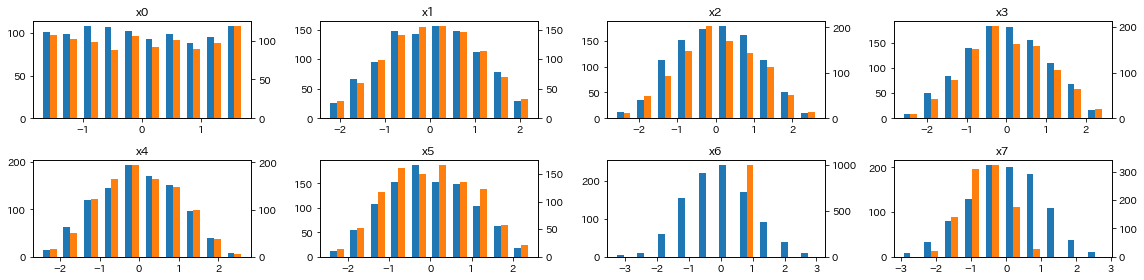

## Counterfactual
target=x6

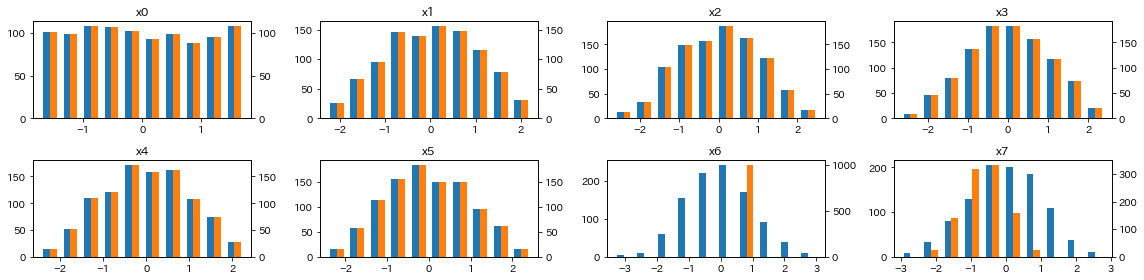

In [5]:
class LinearModel(gcm.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient_ = coefficient.reshape(1, -1)

    def fit(self, X, Y):
        pass

    def predict(self, X):
        return (self.coefficient_ @ X.T).T

    def clone(self):
        return LinearModel(self.coefficient)

def to_dowhy_gcm_model(adj, X):
    causal_graph = nx.from_pandas_adjacency(
        pd.DataFrame(adj.T, columns=X.columns, index=X.columns),
        create_using=nx.DiGraph
    )
    model = gcm.InvertibleStructuralCausalModel(causal_graph)

    for name, coefs in zip(X.columns, adj):
        if np.isclose(coefs, 0).all():
            m = gcm.EmpiricalDistribution()
        else:
            coefs = coefs[~np.isclose(coefs, 0)]
            m = gcm.AdditiveNoiseModel(LinearModel(coefs))
        model.set_causal_mechanism(name, m)

    gcm.fit(model, X)
        
    return model

model = to_dowhy_gcm_model(est_adj, X)

# ACE
ace = gcm.average_causal_effect(
    model,
    "x7",
    {"x6": lambda _: 1},
    {"x6": lambda x: 0},
    num_samples_to_draw=10000
)
display(Markdown("## ACE\nx6->x7"))
display(Markdown(f"estimated={ace:.2f}, truth={true_B[7, 6]:.2f}"))

# intervention
interv_samples = gcm.interventional_samples(model, {"x6": lambda _: 1}, num_samples_to_draw=len(X))

display(Markdown("## Intervention\ntarget=x6"))
fig, axes = plt.subplots(2, 4, figsize=(16, 4))
for ax, (name, x), (name2, interv) in zip(axes.flatten(), X.items(), interv_samples.items()):
    r = (min(*x, *interv), max(*x, *interv))

    bins = 10
    hist, edges = np.histogram(x, range=r, bins=bins)
    hist2, edges2 = np.histogram(interv, range=r, bins=bins)

    xt = (edges[:-1] + edges[1:]) / 2
    w = abs(r[1] - r[0]) / bins / 3
    ax.bar(xt - w/2, hist, width=w, color="tab:blue")
    ax.twinx().bar(xt + w/2, hist2, width=w, color="tab:orange")
    ax.set_title(name)

plt.tight_layout()
plt.show()

# counterfactual
cf_samples = gcm.counterfactual_samples(model, {"x6": lambda _: 1}, observed_data=X)

display(Markdown("## Counterfactual\ntarget=x6"))
fig, axes = plt.subplots(2, 4, figsize=(16, 4))
for ax, (name, x), (name2, cf) in zip(axes.flatten(), X.items(), cf_samples.items()):
    r = (min(*x, *cf), max(*x, *cf))

    bins = 10
    hist, edges = np.histogram(x, range=r, bins=bins)
    hist2, edges2 = np.histogram(cf, range=r, bins=bins)

    xt = (edges[:-1] + edges[1:]) / 2
    w = abs(r[1] - r[0]) / bins / 3
    ax.bar(xt - w/2, hist, width=w, color="tab:blue")
    ax.twinx().bar(xt + w/2, hist2, width=w, color="tab:orange")
    ax.set_title(name)

plt.tight_layout()
plt.show()